In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Diabetes study

**Index**

1. [Problem understanding](#Problem-understanding)
2. [Data understanding](#Data-understanding)
3. [Data preparation](#data-preparation)

<a id="problem-understanding"></a>
## Problem understanding

- Diabetes is a major contributor to risk for hospital readmission, representing nearly one-fifth of all 30-day unplanned hospital readmissions. (Soh et al. 2020)
- <u>Patient characteristics may affect the outcomes</u> (such as gender, age, race, and comorbidities) (Soh et al. 2020)
- Early hospital readmissions have been recognized as a common and costly occurrence, particularly among elderly and high risk patients. One in five Medicare beneficiaries is readmitted within 30 days, for example, at a cost of over $26 billion per year.1 To encourage improvement in the quality of care and a reduction in unnecessary health expense; policymakers, reimbursement strategists, and the United States government have made reducing 30-day hospital readmissions a national priority.2–4 Achieving this goal, however, requires more complete understanding of the underlying causes of readmission. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4249925/

<u>**Objective**</u>

In this work I will try to:

- Create a predictive model for early readmission (i.e. unplanned readmissions that happen within 30 days of discharge from the initial admission). Such a model could help plan interventions for high-risk patients and reduce costs for both patients and hospitals.
- Point out patterns and insights about readmissions, and answer the following questions:
  - Which variables are the strongest readmission predictors?
  - Given that HbA1c values are key for planning the diabetic patient's medication (according to the literature), how often HbA1c exams are asked by physicians in the inpatient setting?


<a id="data-understanding"></a>
## Data understanding

The data set comprises two files, `diabetic_data.csv` and `IDs_mapping.csv`. The former contains anonymized medical data that were collected during 100k encounters accross several hospitals in nearly a decade. The latter contains a legend for some of the numerical categories (like admission type and discharge disposition).

In [37]:
df = pd.read_csv("../data/diabetic_data.zip")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Missing values are represented by question marks in this data set. I will replace these with np.nan, so I can use Pandas' default methods to view and work with missing data as NaNs.

In [38]:
df.replace("?", np.nan, inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Overral view of the dataframe, including missing values and dtypes:

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Percentage of missing vales for each column:

I need more details about possible values. Knowing the variable's dtypes only won't be enough, so let's see some examples of what to expect.

In [40]:
print("Variable              Unique     % Missing  Examples")
print("="*100)
for column in df:
    uniques = set(df[column])
    n_uniques = len(uniques)
    missing = df[column].isnull().mean()*100
    examples = list(uniques)[:5]
    output = "{:<25} {:<10} {:<6.1f} {:<20}".format(column, n_uniques, missing, str(examples))
    print(output)
    

Variable              Unique     % Missing  Examples
encounter_id              101766     0.0    [77856768, 173015040, 84934662, 273678342, 17563668]
patient_nbr               71518      0.0    [33947649, 92667906, 82706436, 83623941, 128319494]
race                      6          2.2    [nan, 'AfricanAmerican', 'Caucasian', 'Other', 'Asian']
gender                    3          0.0    ['Unknown/Invalid', 'Female', 'Male']
age                       10         0.0    ['[80-90)', '[20-30)', '[50-60)', '[90-100)', '[70-80)']
weight                    10         96.9   [nan, '[150-175)', '[50-75)', '[0-25)', '[25-50)']
admission_type_id         8          0.0    [1, 2, 3, 4, 5]     
discharge_disposition_id  26         0.0    [1, 2, 3, 4, 5]     
admission_source_id       17         0.0    [1, 2, 3, 4, 5]     
time_in_hospital          14         0.0    [1, 2, 3, 4, 5]     
payer_code                18         39.6   [nan, 'UN', 'MP', 'SP', 'MD']
medical_specialty         73         49.1 

### IDs Mapping

Now taking a look at `IDs_mapping.csv`, the file isn't in standard CSV format. It's actually a text file mapping numerical categories to strings. Using this file, I'll replace each number with the appropriate name in the original dataframe.

In [41]:
# Map for admission_type_id
admtype_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=0, nrows=8)

# Map for discharge_disposition_id
discharge_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=10, nrows=30)

# Map for admission_source_id
admsrc_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=42, nrows=25)

In [42]:
admsrc_map.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


### Data set characteristics

- Covers a 10-year span (1999-2008).
- Hospital admissions in the data set are supposed to be diabetic-related **only**.
- Lab tests were performed during admission.
- Medications were administered during admission.
- Data set contains <u>multiple readmissions of the same people</u>.
- Missing values are represented by "?"
  - `weight` variable is nearly useless, with about 97% of missing values.
  - `payercode` could be an useful variable, but has a concerning number of missing values (around 40%)
  - `medical_specialty` has half of its values missing.
- Lots of low-variance variables in this data set (e.g. `examide` and `citoglipton` have only 1 unique value), which won't add to the model's predictive power.
- `diag_1` to `diag_3` columns have both strings and floating points. Googling the keyword "diagnosis" plus some of these cryptic codes showed that they are, in fact, ICD-9-CM Diagnosis Codes (e.g. 427 = Cardiac dysrhythmias, E852 =  Accidental poisoning by other sedatives and hypnotics)

**Target variable:** 30-day remission, i.e. unplanned or unexpected readmission to the same hospital within 30 days of being discharged.

<a id="data-preparation"></a>
## Data preparation


### Removing duplicates

There are a few rows in the data set that refer to the same patient number. Most machine learning models require the observations to be independent from each other. More specifically, the assumption is that observations shouldn't come from repeated measurements, so these will be deleted.

In [43]:
print("df size before:", df.shape[0])
df2 = df.drop_duplicates(subset="patient_nbr", keep="first")
print("df size after:", df2.shape[0])

df size before: 101766
df size after: 71518


### Dropped features

- `encounter_id`, `patient_nbr`, and `payer_code`
- `weight`: too many missing values.
- `examide` and `citoglipton`: they have only one value, thus no predictive power.
- `diag_2` and `diag_ 3`: in the inpatient setting, the primary diagnosis is the most serious and/or resource-intensive during the hospitalization or the inpatient encounter. https://www.hcpro.com/HIM-324035-5707/QA-Primary-principal-and-secondary-diagnoses.html

In [44]:
df3 = df2.drop(["encounter_id","patient_nbr","payer_code","weight","examide","citoglipton", "diag_2", "diag_3"], axis=1)

### Modified features

#### Missing values

First, fill NaNs with "Unknown" to account for this value.

In [45]:
df3["medical_specialty"] = df3["medical_specialty"].fillna("Unknown")
df3["race"] = df3["race"].fillna("Unknown")

<AxesSubplot:>

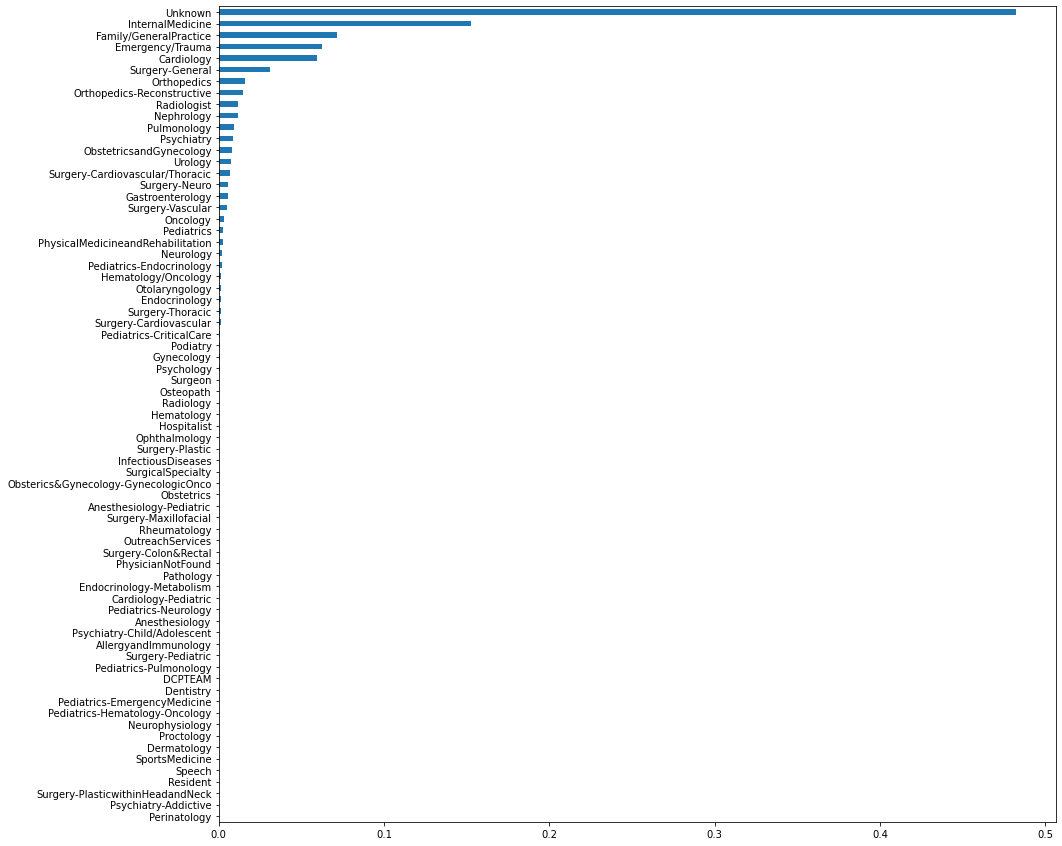

In [46]:
plt.figure(figsize=(15,15))
df3.medical_specialty.value_counts(ascending=True, normalize=True).plot(kind="barh")

I'm going to limit the `medical_specialty` feature to just those that are most abudant, plus "Endocrinology-Metabolism", which makes sense since they are the type of physicians most apt to handle diabetic admissions. All other categories will be replaced by "Other".

In [47]:
specialties = df3.medical_specialty.value_counts(normalize=True)
specialties = [
    "Unknown",
    "InternalMedicine",
    "Family/GeneralPractice", 
    "Emergency/Trauma",
    "Cardiology",
    "Endocrinology-Metabolism"
]
df3["medical_specialty"] = df3["medical_specialty"].apply(lambda x: x if x in specialties else "Other")

#### diag_1, diag_2, and diag_3

The diagnosis features are represented by ICD-9 codes. The idea here is to condensate the hundreds of codes into just a few major groups. 

There are hundreds of different diseases being entered as the `diag`s features, so to avoid ending up with too many features after one-hot encoding them, I'll group them into a few major categories according to the list of ICD-9 codes on Wikipedia: 

    List of ICD-9 codes 001–139: infectious and parasitic diseases
    List of ICD-9 codes 140–239: neoplasms
    List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
    List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
    List of ICD-9 codes 290–319: mental disorders
    List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
    List of ICD-9 codes 390–459: diseases of the circulatory system
    List of ICD-9 codes 460–519: diseases of the respiratory system
    List of ICD-9 codes 520–579: diseases of the digestive system
    List of ICD-9 codes 580–629: diseases of the genitourinary system
    List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
    List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
    List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
    List of ICD-9 codes 740–759: congenital anomalies
    List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
    List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
    List of ICD-9 codes 800–999: injury and poisoning
    List of ICD-9 codes E and V codes: external causes of injury and supplemental classification

In [48]:
def icd(code):
    """Converts ICD-9 code in string format into a descriptive major category.
    ---
    code : int
    The ICD-9 encoded diagonisis
    
    return : str
    A major diagnostic category.
    """
    try:
        code = int(code)
    except ValueError:
        return "Other"
    if (code >= 1) and (code < 140):
        return "Infections"
    elif (code >= 140) and (code < 250):
        return "Endocrine"
    elif (code >= 250) and (code < 251):
        return "Diabetes"
    elif (code >= 251) and (code <280):
        return "Endocrine"
    elif (code >= 280) and (code < 290):
        return "Blood"
    elif (code >= 290) and (code < 320):
        return "Mental"
    elif (code >= 320) and (code < 390):
        return "Nervous system"
    elif (code >= 390) and (code < 460):
        return "Circulatory"
    elif (code >= 460) and (code < 520):
        return "Respiratory"
    elif (code >= 520) and (code < 580):
        return "Digestive"
    elif (code >= 580) and (code < 630):
        return "Genitourinary" 
    elif (code >= 630) and (code < 680):
        return "Pregnancy complications"
    elif (code >= 680) and (code < 710):
        return "Skin"
    elif (code >= 710) and (code < 740):
        return "Musculoskeletal"
    else: 
        return "Other"
    
    

In [49]:
df4 = df3.copy()
df4["diag_1"] = df4["diag_1"].apply(icd)

#### Age

The age group feature in this data set is an ordinal variable, therefore it could be turned into a numerical variable by replacing each group with their means, thus avoid creating too many new features after the one-hot encoding process.

In [50]:
age_map = {'[0-10)': 5,
           '[10-20)': 15,
           '[20-30)': 25,
           '[30-40)': 35,
           '[40-50)': 45,
           '[50-60)': 55,
           '[60-70)': 65,
           '[70-80)': 75,
           '[80-90)': 85,
           '[90-100)': 95}

df4["age"].replace(age_map, inplace=True)

### Glucose serum test result (max_glu_serum) and A1c test

This variable indicates the range of the result if the test was not taken. It can be converted into an ordinal variable and spare the creation of unnecessary one-hot features. According to the [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451), a blood sugar level less than 140 mg/dL is normal. A reading between 140 and 199 mg/dL indicates prediabetes. A reading of more than 200 mg/dL after two hours indicates diabetes.

However, the data set isn't clear whether the glucose serum test was made during fasting or at random, so the "official" ranges from the Mayo Clinic may be not be used as a basis for comparison.

According to the literature, adjusting the patient's medication according to HbA1C levels can diminish early readmission rates. Therefore, this new variable is going to be incorporated into the model, and will be 0 if `A1Cresult` is "none" or 1 otherwise. So I want a new variable to check whether a glucose was ordered.

In [51]:
df4["A1C_tested"] = df["A1Cresult"].apply(lambda x: 0 if x == "None" else 1)
df4["max_glu_serum_tested"] = df["max_glu_serum"].apply(lambda x: 0 if x == "None" else 1)

In [52]:
df4 = pd.get_dummies(df4, columns=["max_glu_serum", "A1Cresult"])

#### Target variable (readmitted)

In [53]:
df4['readmitted'] = df4['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

## Modeling

In [54]:
df4.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'number_diagnoses', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'A1C_tested', 'max_glu_serum_tested', 'max_glu_serum_>200',
       'max_glu_serum_>300', 'max_glu_serum_None', 'max_glu_serum_Norm',
       'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm'],
      dtype='object')

In [55]:
df5 = df4.drop(['admission_type_id',
       'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'number_diagnoses', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'A1C_tested', 'max_glu_serum_tested', 'max_glu_serum_>200',
       'max_glu_serum_>300', 'max_glu_serum_None', 'max_glu_serum_Norm',
       'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm'], axis=1])

KeyError: "['A1Cresult', 'max_glu_serum'] not in index"

In [ ]:
df5.info()

## Evaluation